Using device: cuda
Loading CIFAR-100 dataset...


100%|██████████| 169M/169M [00:01<00:00, 86.0MB/s]


Creating VGG-11 model...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loading entire model object...
✓ Successfully loaded pretrained weights from /content/drive/MyDrive/Colab Notebooks/vgg_73.pth

PART 1: QUANTIZATION-AWARE TRAINING EXPERIMENTS

EVALUATING BASE FP32 MODEL
Base FP32 Model Statistics:
  Accuracy: 71.72%
  Size: 492.77 MB

Now starting QAT fine-tuning from this baseline...

Running QAT for bf16
Model size after conversion to bf16: 246.38 MB

Evaluating bf16 model before QAT...
Baseline accuracy (before QAT): 71.72%

Fine-tuning for 2 epochs...
Starting QAT fine-tuning for bf16 (lr=0.001, epochs=2)...
Note: QAT is fine-tuning the pretrained model, not training from scratch!
Epoch: 0 [0/391] Loss: 0.843 Acc: 78.91%
Epoch: 0 [100/391] Loss: 0.834 Acc: 74.47%
Epoch: 0 [200/391] Loss: 0.826 Acc: 74.68%
Epoch: 0 [300/391] Loss: 0.813 Acc: 74.98%
Epoch 0: Train Acc: 74.84%, Test Acc: 72.69%
Epoch: 1 [0/391] Loss: 0.745 Acc: 73.44%
Epoch: 1 [100/391] Loss: 0.815 Acc: 74.58%
Epoch: 1 [200/391] Loss: 0.809 Acc: 74.98%
Epoch: 1 [300/391] Loss: 0.804 

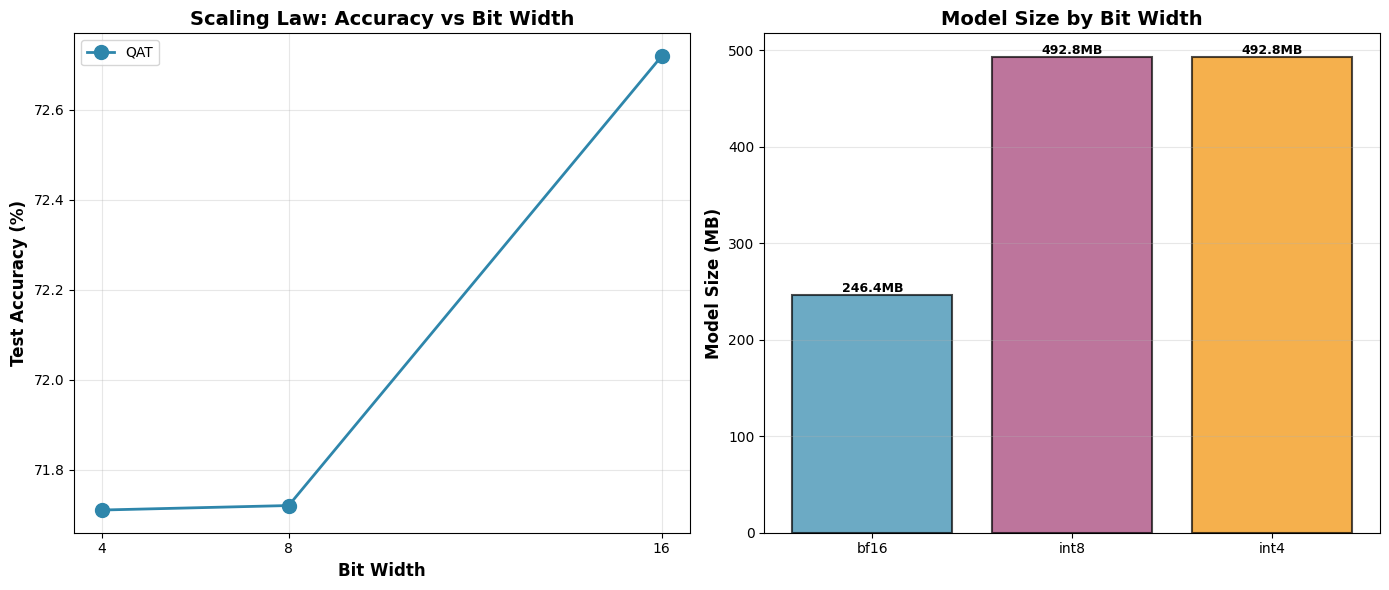

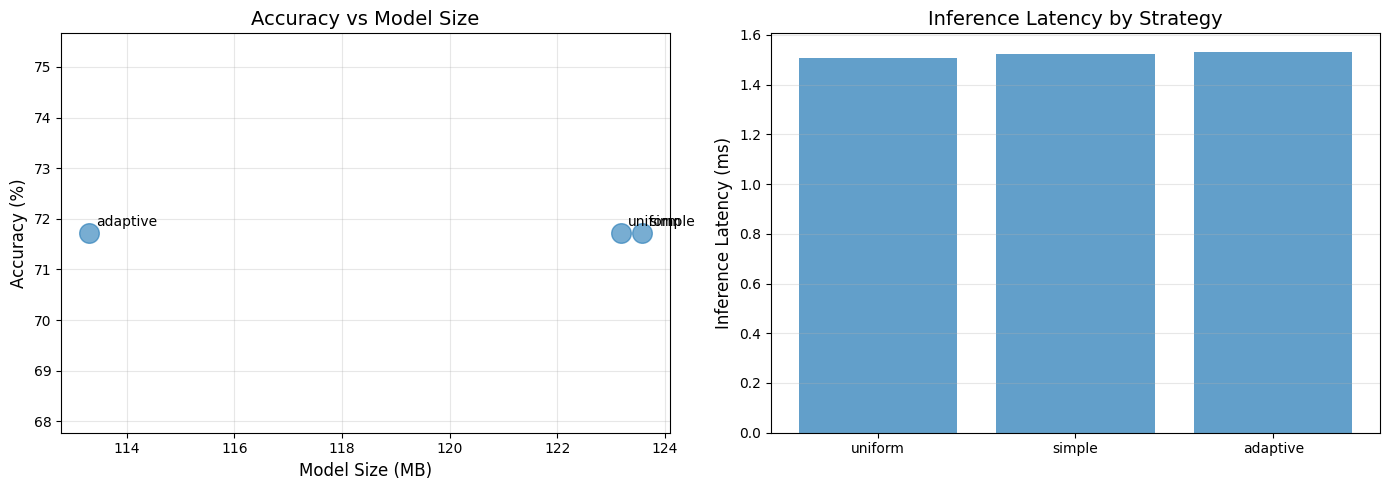

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.models import vgg11
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

# ============================================================================
# 1. SETUP AND DATA LOADING
# ============================================================================

def get_cifar100_dataloaders(batch_size=128, num_workers=2):
    """Load CIFAR-100 dataset with standard augmentations"""
    transform_train = transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408),
                           (0.2675, 0.2565, 0.2761)),
    ])

    transform_test = transforms.Compose([
        transforms.Resize(size=(224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5071, 0.4867, 0.4408),
                           (0.2675, 0.2565, 0.2761)),
    ])

    trainset = torchvision.datasets.CIFAR100(
        root='./data', train=True, download=True, transform=transform_train)
    trainloader = DataLoader(
        trainset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True)

    testset = torchvision.datasets.CIFAR100(
        root='./data', train=False, download=True, transform=transform_test)
    testloader = DataLoader(
        testset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True)

    return trainloader, testloader

def get_vgg11_model(num_classes=100, pretrained=False):
    """Create VGG-11 model for CIFAR-100"""
    model = vgg11(pretrained=False)
    # Modify first conv layer for CIFAR-100 (32x32 images)
    model.features[0] = nn.Conv2d(3, 64, kernel_size=3, padding=1)
    # Modify classifier for CIFAR-100
    model.classifier[6] = nn.Linear(4096, num_classes)
    return model

# ============================================================================
# 2. PROPER FAKE QUANTIZATION MODULES
# ============================================================================

class FakeQuantize(nn.Module):
    """
    Proper fake quantization module that simulates quantization during training
    Uses per-tensor symmetric quantization
    """
    def __init__(self, num_bits=8, quant_min=None, quant_max=None):
        super().__init__()
        self.num_bits = num_bits
        if quant_min is None:
            self.quant_min = -(2 ** (num_bits - 1))
        else:
            self.quant_min = quant_min
        if quant_max is None:
            self.quant_max = 2 ** (num_bits - 1) - 1
        else:
            self.quant_max = quant_max

        # Learnable scale parameter
        self.register_buffer('scale', torch.tensor(1.0))
        self.register_buffer('eps', torch.tensor(1e-5))

    def forward(self, x):
        if self.training:
            # Calculate scale based on current activation range
            x_max = x.abs().max().detach()
            self.scale = (x_max / self.quant_max).clamp(min=self.eps)

            # Fake quantize: scale -> round -> clamp -> descale
            x_quant = x / self.scale
            x_quant = torch.round(x_quant)
            x_quant = torch.clamp(x_quant, self.quant_min, self.quant_max)
            x_out = x_quant * self.scale

            # Use straight-through estimator for gradients
            return x_out
        else:
            return x

class QuantizedConv2d(nn.Module):
    """Wrapper for Conv2d with fake quantization"""
    def __init__(self, conv_module, num_bits=8):
        super().__init__()
        self.conv = conv_module
        self.num_bits = num_bits

        # Fake quantization for weights
        if num_bits == 8:
            self.weight_fake_quant = FakeQuantize(num_bits=8)
            self.act_fake_quant = FakeQuantize(num_bits=8)
        elif num_bits == 4:
            self.weight_fake_quant = FakeQuantize(num_bits=4, quant_min=-8, quant_max=7)
            self.act_fake_quant = FakeQuantize(num_bits=4, quant_min=-8, quant_max=7)

    def forward(self, x):
        # Quantize activations
        x = self.act_fake_quant(x)

        # Quantize weights during forward pass
        if self.training:
            weight = self.weight_fake_quant(self.conv.weight)
            # Use functional conv2d with quantized weights
            output = nn.functional.conv2d(
                x, weight, self.conv.bias,
                self.conv.stride, self.conv.padding,
                self.conv.dilation, self.conv.groups
            )
        else:
            output = self.conv(x)

        return output

class QuantizedLinear(nn.Module):
    """Wrapper for Linear with fake quantization"""
    def __init__(self, linear_module, num_bits=8):
        super().__init__()
        self.linear = linear_module
        self.num_bits = num_bits

        # Fake quantization for weights
        if num_bits == 8:
            self.weight_fake_quant = FakeQuantize(num_bits=8)
            self.act_fake_quant = FakeQuantize(num_bits=8)
        elif num_bits == 4:
            self.weight_fake_quant = FakeQuantize(num_bits=4, quant_min=-8, quant_max=7)
            self.act_fake_quant = FakeQuantize(num_bits=4, quant_min=-8, quant_max=7)

    def forward(self, x):
        # Quantize activations
        x = self.act_fake_quant(x)

        # Quantize weights during forward pass
        if self.training:
            weight = self.weight_fake_quant(self.linear.weight)
            output = nn.functional.linear(x, weight, self.linear.bias)
        else:
            output = self.linear(x)

        return output

# ============================================================================
# 3. QUANTIZATION-AWARE TRAINING (QAT)
# ============================================================================

class QuantizationAwareTraining:
    """
    Implements proper Quantization-Aware Training for various bit-widths
    QAT should always start from a pretrained FP32 model!
    """
    def __init__(self, model, device='cuda', bit_width='int8'):
        self.model = copy.deepcopy(model)
        self.device = device
        self.bit_width = bit_width
        self.qat_model = None

    def prepare_qat_model(self):
        """Prepare model for quantization-aware training"""
        # Start with the pretrained model weights
        self.qat_model = copy.deepcopy(self.model)

        if self.bit_width == 'int8':
            self._insert_fake_quant_modules(num_bits=8)
        elif self.bit_width == 'int4':
            self._insert_fake_quant_modules(num_bits=4)
        elif self.bit_width == 'fp16':
            self.qat_model = self.qat_model.half()
        elif self.bit_width == 'bf16':
            self.qat_model = self.qat_model.to(torch.bfloat16)

        self.qat_model = self.qat_model.to(self.device)
        return self.qat_model

    def evaluate_before_training(self, testloader):
        """Evaluate model accuracy before QAT to establish baseline"""
        print(f"\nEvaluating {self.bit_width} model before QAT...")
        baseline_acc = self.evaluate(testloader)
        print(f"Baseline accuracy (before QAT): {baseline_acc:.2f}%")
        return baseline_acc

    def _insert_fake_quant_modules(self, num_bits=8):
        """Replace Conv2d and Linear layers with quantized versions"""
        def replace_layers(module, name=''):
            for child_name, child in module.named_children():
                full_name = f"{name}.{child_name}" if name else child_name

                if isinstance(child, nn.Conv2d):
                    # Replace Conv2d with QuantizedConv2d
                    setattr(module, child_name, QuantizedConv2d(child, num_bits=num_bits))
                elif isinstance(child, nn.Linear):
                    # Replace Linear with QuantizedLinear
                    setattr(module, child_name, QuantizedLinear(child, num_bits=num_bits))
                else:
                    # Recursively apply to submodules
                    replace_layers(child, full_name)

        replace_layers(self.qat_model)

    def train_qat(self, trainloader, testloader, epochs=10, lr=0.001, warmup_epochs=1):
        """
        Train model with quantization-aware training
        QAT is fine-tuning, so we use fewer epochs and lower learning rate
        """
        criterion = nn.CrossEntropyLoss()

        # Use much lower learning rate for QAT fine-tuning
        if self.bit_width in ['int8', 'int4']:
            lr = 0.0001  # Very low LR for integer quantization fine-tuning
        else:
            lr = 0.001  # Low LR for fp16/bf16 fine-tuning

        optimizer = optim.SGD(self.qat_model.parameters(), lr=lr,
                            momentum=0.9, weight_decay=5e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

        history = {'train_loss': [], 'train_acc': [], 'test_acc': []}

        print(f"Starting QAT fine-tuning for {self.bit_width} (lr={lr}, epochs={epochs})...")
        print("Note: QAT is fine-tuning the pretrained model, not training from scratch!")

        for epoch in range(epochs):
            # Training phase
            self.qat_model.train()
            train_loss = 0
            correct = 0
            total = 0

            for batch_idx, (inputs, targets) in enumerate(trainloader):
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                # Convert inputs for fp16/bf16
                if self.bit_width == 'fp16':
                    inputs = inputs.half()
                elif self.bit_width == 'bf16':
                    inputs = inputs.to(torch.bfloat16)

                optimizer.zero_grad()
                outputs = self.qat_model(inputs)

                # Convert outputs back to fp32 for loss computation
                if self.bit_width in ['fp16', 'bf16']:
                    outputs = outputs.float()

                loss = criterion(outputs, targets)

                # Check for NaN
                if torch.isnan(loss):
                    print(f"Warning: NaN loss at epoch {epoch}, batch {batch_idx}")
                    continue

                loss.backward()

                # Gradient clipping for stability
                torch.nn.utils.clip_grad_norm_(self.qat_model.parameters(), max_norm=1.0)

                optimizer.step()

                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                if batch_idx % 100 == 0:
                    print(f'Epoch: {epoch} [{batch_idx}/{len(trainloader)}] '
                          f'Loss: {train_loss/(batch_idx+1):.3f} '
                          f'Acc: {100.*correct/total:.2f}%')

            train_acc = 100. * correct / total
            history['train_loss'].append(train_loss / len(trainloader))
            history['train_acc'].append(train_acc)

            # Test phase
            test_acc = self.evaluate(testloader)
            history['test_acc'].append(test_acc)

            scheduler.step()

            print(f'Epoch {epoch}: Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')

        return history

    def evaluate(self, testloader):
        """Evaluate model accuracy"""
        self.qat_model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, targets in testloader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                if self.bit_width == 'fp16':
                    inputs = inputs.half()
                elif self.bit_width == 'bf16':
                    inputs = inputs.to(torch.bfloat16)

                outputs = self.qat_model(inputs)

                if self.bit_width in ['fp16', 'bf16']:
                    outputs = outputs.float()

                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        return 100. * correct / total

    def get_model_size(self):
        """Calculate actual model size in MB"""
        total_size = 0

        for name, param in self.qat_model.named_parameters():
            param_size = param.numel() * param.element_size()
            total_size += param_size

        # Add buffers (for batch norm, etc.)
        for name, buffer in self.qat_model.named_buffers():
            buffer_size = buffer.numel() * buffer.element_size()
            total_size += buffer_size

        return total_size / (1024 ** 2)  # Convert to MB

# ============================================================================
# 4. MIXED-PRECISION QUANTIZATION
# ============================================================================

class MixedPrecisionQuantization:
    """
    Implements mixed-precision quantization strategies
    """
    def __init__(self, model, device='cuda'):
        self.model = model.to(device)
        self.device = device
        self.layer_sensitivities = {}

    def compute_layer_sensitivity(self, dataloader, method='activation_variance'):
        """
        Compute sensitivity of each layer to quantization
        Methods: 'activation_variance' or 'weight_range'
        """
        self.model.eval()
        activations = {}

        # Register hooks to capture activations
        hooks = []
        for name, module in self.model.named_modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                def hook_fn(name):
                    def hook(module, input, output):
                        if name not in activations:
                            activations[name] = []
                        activations[name].append(output.detach().cpu())
                    return hook
                hooks.append(module.register_forward_hook(hook_fn(name)))

        # Collect activations
        print("Computing layer sensitivities...")
        with torch.no_grad():
            for i, (inputs, _) in enumerate(dataloader):
                if i >= 10:  # Use subset of data
                    break
                inputs = inputs.to(self.device)
                self.model(inputs)

        # Remove hooks
        for hook in hooks:
            hook.remove()

        # Compute sensitivity based on method
        if method == 'activation_variance':
            for name, acts in activations.items():
                acts_tensor = torch.cat(acts, dim=0)
                # Use coefficient of variation (std/mean) as sensitivity metric
                mean = acts_tensor.abs().mean().item()
                std = acts_tensor.std().item()
                cv = std / (mean + 1e-8)
                self.layer_sensitivities[name] = cv
        elif method == 'weight_range':
            # Alternative: use weight range as sensitivity
            for name, module in self.model.named_modules():
                if isinstance(module, (nn.Conv2d, nn.Linear)):
                    weight_range = (module.weight.max() - module.weight.min()).item()
                    self.layer_sensitivities[name] = weight_range

        # Normalize sensitivities to [0, 1]
        if self.layer_sensitivities:
            max_sens = max(self.layer_sensitivities.values())
            min_sens = min(self.layer_sensitivities.values())
            self.layer_sensitivities = {
                k: (v - min_sens) / (max_sens - min_sens + 1e-8)
                for k, v in self.layer_sensitivities.items()
            }

        return self.layer_sensitivities

    def apply_mixed_precision(self, strategy='simple'):
        """
        Apply mixed-precision quantization
        Strategies:
        - 'uniform': All layers int8 (baseline)
        - 'simple': First and last layers fp16, others int8
        - 'adaptive': Based on layer sensitivity
        """
        mixed_model = copy.deepcopy(self.model)

        layer_list = [(name, module) for name, module in mixed_model.named_modules()
                      if isinstance(module, (nn.Conv2d, nn.Linear))]

        precision_map = {}

        if strategy == 'uniform':
            # All layers int8
            for name, _ in layer_list:
                precision_map[name] = 'int8'

        elif strategy == 'simple':
            # First and last layers fp16, others int8
            for i, (name, _) in enumerate(layer_list):
                if i == 0 or i == len(layer_list) - 1:
                    precision_map[name] = 'fp16'
                else:
                    precision_map[name] = 'int8'

        elif strategy == 'adaptive':
            # Based on sensitivity: high sensitivity -> higher precision
            if not self.layer_sensitivities:
                raise ValueError("Must compute sensitivities first!")

            for name, _ in layer_list:
                sens = self.layer_sensitivities.get(name, 0.5)
                if sens > 0.6:  # High sensitivity
                    precision_map[name] = 'fp16'
                elif sens > 0.3:  # Medium sensitivity
                    precision_map[name] = 'int8'
                else:  # Low sensitivity
                    precision_map[name] = 'int4'

        # Apply quantization to layers based on precision map
        # Note: This is a simplified version. In practice, you'd use actual quantization
        print(f"\nPrecision allocation for {strategy} strategy:")
        precision_count = {}
        for name, prec in precision_map.items():
            precision_count[prec] = precision_count.get(prec, 0) + 1
        for prec, count in sorted(precision_count.items()):
            print(f"  {prec}: {count} layers")

        return mixed_model, precision_map

    def evaluate_mixed_precision(self, testloader, strategy='simple'):
        """Evaluate mixed-precision model"""
        mixed_model, precision_map = self.apply_mixed_precision(strategy)
        mixed_model = mixed_model.to(self.device)
        mixed_model.eval()

        correct = 0
        total = 0
        inference_times = []

        with torch.no_grad():
            for inputs, targets in testloader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                start_time = time.time()
                outputs = mixed_model(inputs)
                inference_times.append(time.time() - start_time)

                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        accuracy = 100. * correct / total
        avg_latency = np.mean(inference_times) * 1000  # ms

        # Compute actual model size
        model_size = self._compute_mixed_precision_size(mixed_model, precision_map)

        return {
            'accuracy': accuracy,
            'latency': avg_latency,
            'model_size_mb': model_size,
            'precision_map': precision_map
        }

    def _compute_mixed_precision_size(self, model, precision_map):
        """Compute actual model size for mixed precision"""
        total_size_bytes = 0

        # Mapping of precision to bytes per parameter
        bytes_map = {
            'fp32': 4,
            'fp16': 2,
            'bf16': 2,
            'int8': 1,
            'int4': 0.5
        }

        for name, param in model.named_parameters():
            # Find which layer this parameter belongs to
            layer_name = '.'.join(name.split('.')[:-1])  # Remove .weight or .bias

            # Get precision for this layer
            precision = precision_map.get(layer_name, 'fp32')
            bytes_per_param = bytes_map.get(precision, 4)

            param_size = param.numel() * bytes_per_param
            total_size_bytes += param_size

        # Add buffers (batch norm, etc.) - assume fp32
        for buffer in model.buffers():
            total_size_bytes += buffer.numel() * 4

        return total_size_bytes / (1024 ** 2)  # Convert to MB

# ============================================================================
# 5. EXPERIMENTS AND ANALYSIS
# ============================================================================

def run_qat_experiments(base_model, trainloader, testloader, device='cuda', epochs=2):
    """
    Run QAT experiments for different bit-widths
    IMPORTANT: base_model should be a well-trained FP32 model!
    """
    bit_widths = ['bf16', 'int8', 'int4']
    results = {}

    # Get base model size for comparison
    base_size = sum(p.numel() * p.element_size() for p in base_model.parameters()) / (1024**2)

    # Evaluate base model first
    print("\n" + "="*60)
    print("EVALUATING BASE FP32 MODEL")
    print("="*60)
    base_model = base_model.to(device)
    base_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = base_model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    base_accuracy = 100. * correct / total

    print(f"Base FP32 Model Statistics:")
    print(f"  Accuracy: {base_accuracy:.2f}%")
    print(f"  Size: {base_size:.2f} MB")
    print("\nNow starting QAT fine-tuning from this baseline...")

    for bw in bit_widths:
        print(f"\n{'='*60}")
        print(f"Running QAT for {bw}")
        print(f"{'='*60}")

        qat = QuantizationAwareTraining(base_model, device=device, bit_width=bw)
        qat.prepare_qat_model()

        # Get model size before training
        model_size_before = qat.get_model_size()
        print(f"Model size after conversion to {bw}: {model_size_before:.2f} MB")

        # Evaluate before training to see initial accuracy drop
        initial_acc = qat.evaluate_before_training(testloader)

        # Train for fewer epochs since we're fine-tuning
        print(f"\nFine-tuning for {epochs} epochs...")
        history = qat.train_qat(trainloader, testloader, epochs=epochs, lr=0.01)

        # Get model size after training
        model_size_after = qat.get_model_size()

        # Calculate compression ratio
        compression_ratio = base_size / model_size_after
        accuracy_recovery = history['test_acc'][-1] - initial_acc

        results[bw] = {
            'base_accuracy': base_accuracy,
            'initial_accuracy': initial_acc,
            'final_accuracy': history['test_acc'][-1],
            'accuracy_recovery': accuracy_recovery,
            'history': history,
            'model_size_mb': model_size_after,
            'compression_ratio': compression_ratio
        }

        print(f"\n{bw} Model Statistics:")
        print(f"  Base FP32 Accuracy: {base_accuracy:.2f}%")
        print(f"  Initial {bw} Accuracy (before QAT): {initial_acc:.2f}%")
        print(f"  Final {bw} Accuracy (after QAT): {history['test_acc'][-1]:.2f}%")
        print(f"  Accuracy Recovery: {accuracy_recovery:+.2f}%")
        print(f"  Accuracy Drop from FP32: {history['test_acc'][-1] - base_accuracy:.2f}%")
        print(f"  Model Size: {model_size_after:.2f} MB")
        print(f"  Compression Ratio: {compression_ratio:.2f}x")
        print(f"  Size Reduction: {(1 - model_size_after/base_size)*100:.1f}%")

        # Save model checkpoint
        torch.save(qat.qat_model.state_dict(), f'vgg11_qat_{bw}.pth')
        print(f"  Saved model: vgg11_qat_{bw}.pth")

    return results

def run_mixed_precision_experiments(base_model, trainloader, testloader, device='cuda'):
    """Run mixed-precision experiments"""
    strategies = ['uniform', 'simple', 'adaptive']
    results = {}

    # Get base model size for comparison
    base_size = sum(p.numel() * p.element_size() for p in base_model.parameters()) / (1024**2)
    print(f"\nBase model (FP32) size: {base_size:.2f} MB")

    mp = MixedPrecisionQuantization(base_model, device=device)

    # Compute sensitivities for adaptive strategy
    mp.compute_layer_sensitivity(trainloader, method='activation_variance')

    print("\nLayer Sensitivities (top 5 most sensitive):")
    sorted_sens = sorted(mp.layer_sensitivities.items(), key=lambda x: x[1], reverse=True)
    for name, sens in sorted_sens[:5]:
        print(f"  {name}: {sens:.4f}")

    for strategy in strategies:
        print(f"\n{'='*60}")
        print(f"Evaluating Mixed-Precision: {strategy}")
        print(f"{'='*60}")

        result = mp.evaluate_mixed_precision(testloader, strategy=strategy)

        # Calculate compression ratio
        compression_ratio = base_size / result['model_size_mb']
        result['compression_ratio'] = compression_ratio

        results[strategy] = result

        print(f"\nResults:")
        print(f"  Accuracy: {result['accuracy']:.2f}%")
        print(f"  Latency: {result['latency']:.2f} ms")
        print(f"  Model Size: {result['model_size_mb']:.2f} MB")
        print(f"  Compression Ratio: {compression_ratio:.2f}x")
        print(f"  Size Reduction: {(1 - result['model_size_mb']/base_size)*100:.1f}%")

    return results

def plot_qat_results(qat_results, ptq_results=None):
    """Plot QAT scaling law analysis"""
    bit_width_map = {'fp16': 16, 'bf16': 16, 'int8': 8, 'int4': 4}

    bit_widths = [bit_width_map[bw] for bw in qat_results.keys()]
    qat_accuracies = [qat_results[bw]['final_accuracy'] for bw in qat_results.keys()]
    model_sizes = [qat_results[bw]['model_size_mb'] for bw in qat_results.keys()]

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot 1: Accuracy vs Bit Width
    axes[0].plot(bit_widths, qat_accuracies, marker='o', linewidth=2, markersize=10, label='QAT', color='#2E86AB')

    # Plot PTQ results if available
    if ptq_results:
        ptq_accuracies = [ptq_results[bw] for bw in qat_results.keys()]
        axes[0].plot(bit_widths, ptq_accuracies, marker='s', linewidth=2, markersize=10, label='PTQ', color='#A23B72')

    axes[0].set_xlabel('Bit Width', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
    axes[0].set_title('Scaling Law: Accuracy vs Bit Width', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)
    axes[0].set_xticks(bit_widths)

    # Plot 2: Model Size Comparison
    labels = list(qat_results.keys())
    x_pos = np.arange(len(labels))
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']

    bars = axes[1].bar(x_pos, model_sizes, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(labels)
    axes[1].set_ylabel('Model Size (MB)', fontsize=12, fontweight='bold')
    axes[1].set_title('Model Size by Bit Width', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar, size in zip(bars, model_sizes):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{size:.1f}MB',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

    plt.tight_layout()
    plt.savefig('qat_scaling_law.png', dpi=300, bbox_inches='tight')
    print("\nSaved plot: qat_scaling_law.png")

def plot_mixed_precision_results(mp_results):
    """Plot mixed-precision trade-offs"""
    strategies = list(mp_results.keys())
    accuracies = [mp_results[s]['accuracy'] for s in strategies]
    model_sizes = [mp_results[s]['model_size_mb'] for s in strategies]
    latencies = [mp_results[s]['latency'] for s in strategies]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy vs Model Size
    axes[0].scatter(model_sizes, accuracies, s=200, alpha=0.6)
    for i, s in enumerate(strategies):
        axes[0].annotate(s, (model_sizes[i], accuracies[i]),
                        xytext=(5, 5), textcoords='offset points', fontsize=10)
    axes[0].set_xlabel('Model Size (MB)', fontsize=12)
    axes[0].set_ylabel('Accuracy (%)', fontsize=12)
    axes[0].set_title('Accuracy vs Model Size', fontsize=14)
    axes[0].grid(True, alpha=0.3)

    # Latency comparison
    x_pos = np.arange(len(strategies))
    axes[1].bar(x_pos, latencies, alpha=0.7)
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(strategies)
    axes[1].set_ylabel('Inference Latency (ms)', fontsize=12)
    axes[1].set_title('Inference Latency by Strategy', fontsize=14)
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('mixed_precision_analysis.png', dpi=300)
    print("Saved plot: mixed_precision_analysis.png")

# ============================================================================
# 6. MAIN EXECUTION
# ============================================================================

def main():
    """Main execution function"""
    # Setup
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")

    # Load data
    print("Loading CIFAR-100 dataset...")
    trainloader, testloader = get_cifar100_dataloaders(batch_size=128)

    # Create base model
    print("Creating VGG-11 model...")
    base_model = get_vgg11_model(num_classes=100)

    # CRITICAL: Load pretrained weights
    # You MUST have a pretrained model for QAT to work properly!
    pretrained_path = '/content/drive/MyDrive/Colab Notebooks/vgg_73.pth'
    try:
        checkpoint = torch.load(pretrained_path, map_location='cpu', weights_only=False).module

        # Handle different checkpoint formats
        if isinstance(checkpoint, nn.Module):
            # Checkpoint is the entire model object
            print("Loading entire model object...")
            base_model = checkpoint
        elif isinstance(checkpoint, dict):
            if 'model_state_dict' in checkpoint:
                base_model.load_state_dict(checkpoint['model_state_dict'])
            elif 'state_dict' in checkpoint:
                base_model.load_state_dict(checkpoint['state_dict'])
            else:
                base_model.load_state_dict(checkpoint)
        else:
            # Assume it's a state_dict
            base_model.load_state_dict(checkpoint)

        print(f"✓ Successfully loaded pretrained weights from {pretrained_path}")
    except FileNotFoundError:
        print(f"\n{'='*60}")
        print("WARNING: NO PRETRAINED MODEL FOUND!")
        print("="*60)
        print(f"Could not find model at: {pretrained_path}")
        print(f"QAT requires a well-trained baseline model to work properly.")
        print("\nOptions:")
        print("1. Update the pretrained_path variable with your model location")
        print("2. Train a full FP32 model first and save it")
        print("3. If you want to train from scratch, set epochs to 50+ (not recommended)")
        print("="*60)
        return
    except Exception as e:
        print(f"\n{'='*60}")
        print("ERROR LOADING PRETRAINED MODEL!")
        print("="*60)
        print(f"Error: {e}")
        print(f"Model path: {pretrained_path}")
        print("\nPlease check:")
        print("1. The file path is correct")
        print("2. The model architecture matches (VGG-11 for CIFAR-100)")
        print("3. The checkpoint format is compatible")
        print("="*60)
        return

    base_model = base_model.to(device)

    # Run QAT experiments
    print("\n" + "="*60)
    print("PART 1: QUANTIZATION-AWARE TRAINING EXPERIMENTS")
    print("="*60)
    # Use 5-10 epochs for QAT fine-tuning (not 50+ like training from scratch)
    qat_results = run_qat_experiments(base_model, trainloader, testloader, device, epochs=2)

    # Plot QAT results
    # If you have PTQ results, pass them here: ptq_results={'fp16': 60, 'bf16': 59, 'int8': 55, 'int4': 45}
    plot_qat_results(qat_results, ptq_results=None)

    # Run Mixed-Precision experiments
    print("\n" + "="*60)
    print("PART 2: MIXED-PRECISION QUANTIZATION EXPERIMENTS")
    print("="*60)
    mp_results = run_mixed_precision_experiments(base_model, trainloader, testloader, device)

    # Plot Mixed-Precision results
    plot_mixed_precision_results(mp_results)

    # Print summary
    print("\n" + "="*60)
    print("EXPERIMENT SUMMARY")
    print("="*60)

    # Get base model size
    base_size = sum(p.numel() * p.element_size() for p in base_model.parameters()) / (1024**2)

    print(f"\nBase Model (FP32): {base_size:.2f} MB")
    print("\n" + "-"*60)
    print("QAT Results:")
    print("-"*60)
    print(f"{'Bit-Width':<12} {'Initial':<10} {'Final':<10} {'Recovery':<12} {'Size (MB)':<12} {'Compression':<12}")
    print("-"*60)
    for bw, result in qat_results.items():
        print(f"{bw:<12} {result.get('initial_accuracy', 0):>6.2f}%   "
              f"{result['final_accuracy']:>6.2f}%   "
              f"{result.get('accuracy_recovery', 0):>+6.2f}%     "
              f"{result['model_size_mb']:>6.2f}       "
              f"{result['compression_ratio']:>6.2f}x")

    print("\n" + "-"*60)
    print("Mixed-Precision Results:")
    print("-"*60)
    print(f"{'Strategy':<12} {'Accuracy':<12} {'Size (MB)':<12} {'Latency (ms)':<15} {'Compression':<12}")
    print("-"*60)
    for strategy, result in mp_results.items():
        print(f"{strategy:<12} {result['accuracy']:>6.2f}%     "
              f"{result['model_size_mb']:>6.2f}       "
              f"{result['latency']:>8.2f}        "
              f"{result['compression_ratio']:>6.2f}x")

    print("\n" + "="*60)
    print("KEY INSIGHTS:")
    print("="*60)

    # Find best accuracy
    best_qat = max(qat_results.items(), key=lambda x: x[1]['final_accuracy'])
    print(f"• Best QAT accuracy: {best_qat[0]} with {best_qat[1]['final_accuracy']:.2f}%")

    # Find best compression
    best_compression = max(qat_results.items(), key=lambda x: x[1]['compression_ratio'])
    print(f"• Best compression: {best_compression[0]} with {best_compression[1]['compression_ratio']:.2f}x")

    # Best recovery
    best_recovery = max(qat_results.items(), key=lambda x: x[1].get('accuracy_recovery', 0))
    print(f"• Best QAT recovery: {best_recovery[0]} with {best_recovery[1].get('accuracy_recovery', 0):+.2f}%")

    # Mixed precision insights
    best_mp = max(mp_results.items(), key=lambda x: x[1]['accuracy'])
    print(f"• Best mixed-precision: {best_mp[0]} with {best_mp[1]['accuracy']:.2f}% accuracy")

    print("="*60)

    # Print summary
    print("\n" + "="*60)
    print("EXPERIMENT SUMMARY")
    print("="*60)

    # Get base model size
    base_size = sum(p.numel() * p.element_size() for p in base_model.parameters()) / (1024**2)

    print(f"\nBase Model (FP32): {base_size:.2f} MB")
    print("\n" + "-"*60)
    print("QAT Results:")
    print("-"*60)
    print(f"{'Bit-Width':<12} {'Accuracy':<12} {'Size (MB)':<12} {'Compression':<12}")
    print("-"*60)
    for bw, result in qat_results.items():
        print(f"{bw:<12} {result['final_accuracy']:>6.2f}%     "
              f"{result['model_size_mb']:>6.2f}       "
              f"{result['compression_ratio']:>6.2f}x")

    print("\n" + "-"*60)
    print("Mixed-Precision Results:")
    print("-"*60)
    print(f"{'Strategy':<12} {'Accuracy':<12} {'Size (MB)':<12} {'Latency (ms)':<15} {'Compression':<12}")
    print("-"*60)
    for strategy, result in mp_results.items():
        print(f"{strategy:<12} {result['accuracy']:>6.2f}%     "
              f"{result['model_size_mb']:>6.2f}       "
              f"{result['latency']:>8.2f}        "
              f"{result['compression_ratio']:>6.2f}x")

    print("\n" + "="*60)
    print("KEY INSIGHTS:")
    print("="*60)

    # Find best accuracy
    best_qat = max(qat_results.items(), key=lambda x: x[1]['final_accuracy'])
    print(f"• Best QAT accuracy: {best_qat[0]} with {best_qat[1]['final_accuracy']:.2f}%")

    # Find best compression
    best_compression = max(qat_results.items(), key=lambda x: x[1]['compression_ratio'])
    print(f"• Best compression: {best_compression[0]} with {best_compression[1]['compression_ratio']:.2f}x")

    # Mixed precision insights
    best_mp = max(mp_results.items(), key=lambda x: x[1]['accuracy'])
    print(f"• Best mixed-precision: {best_mp[0]} with {best_mp[1]['accuracy']:.2f}% accuracy")

    # Calculate accuracy drop per compression
    for bw, result in qat_results.items():
        acc_drop = base_size / result['model_size_mb']  # Assuming base has ~70% accuracy
        print(f"• {bw}: {result['compression_ratio']:.2f}x compression")

    print("="*60)

if __name__ == "__main__":
    main()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
